In [1]:
%load_ext autoreload
%autoreload 2

# Setup Paths

In [2]:
import os
import pyrootutils
root = pyrootutils.setup_root(
    search_from='.',
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)
hydra_cfg_path = root / "text_classification_problems" / "configs"
os.chdir(root / "text_classification_problems")

In [3]:
import hydra
from hydra import compose, initialize

from pathlib import Path
import numpy as np
import torch
from core.grads import tree_to_device
from core.tracer import KNN, KNNGD, KNNGN
from sklearn.neighbors import KNeighborsClassifier
from text_classification_problems.datamodule import TextClassifierDataModule
from text_classification_problems.modelmodule import TextClassifierModel
from transformers import AutoTokenizer
from tqdm import tqdm

import matplotlib.pyplot as plt

/host/ThangND34/ErrorDetection/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config  

In [4]:
'..' / hydra_cfg_path.relative_to(root)
with initialize(version_base=None, config_path= '../configs'):
    cfg = compose(config_name="tracing", return_hydra_config=True, overrides=["datamodule=imdb", "tracer=gd"])

In [5]:
device = 'cuda:2'

# Load Data and Model

In [6]:
from datamodule import TextClassifierDataModule

In [7]:
checkpoint = torch.load(next(Path("outputs/imdb/flip0.2_bert/125_2023-01-03_19-26-09/checkpoints").glob("epoch=01*.ckpt")), map_location=device)
datamodule_hparams = checkpoint["datamodule_hyper_parameters"] 

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=False
)
dm.prepare_data()
dm.setup("tracing")

In [9]:
net = hydra.utils.instantiate(cfg.net, num_classes=dm.num_classes)
lit_model = TextClassifierModel(
    net=net,
    num_classes=dm.num_classes,
    lr=1e-3,
)
lit_model.load_state_dict(checkpoint["state_dict"])
net = lit_model.net
lit_model.eval()
lit_model.to(device);

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Stats

In [10]:
from core.grads import RuntimeGradientExtractor
from core.tracer import GradientNormalize as GN, GradientCosin as GC, GradientBasedTracer as GD
import torch.nn.functional as F
import pandas as pd
from core.aggregation import cal_neibor_matrices
from text_classification_problems.convert_result import eval_ckpt
from text_classification_problems.run_tracing import register_BatchEncoding
import re
from core.eval import cal_precision_top
from core.mrr import compute_mean_reciprocal_rank
from core.experimental import mahalanobis, viz
from core.aggregation import aggregation
import seaborn as sns

In [11]:
register_BatchEncoding()

## Collecting

In [12]:
from sentence_transformers import SentenceTransformer, util

In [13]:
datamodule_hparams

{'dataset_name': 'imdb',
 'train_batch_size': 64,
 'flip_percent': 0.2,
 'flip_seed': 2147483647,
 'max_seq_length': 128,
 'val_batch_size': 128,
 'test_batch_size': 128,
 'num_workers': 8}

In [14]:
datamodule_hparams["flip_percent"] = 0.2
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
dm = TextClassifierDataModule(
    data_root=os.environ["PYTORCH_DATASET_ROOT"],
    tokenizer=tokenizer,
    **datamodule_hparams,
    use_denoised_data=False
)
dm.prepare_data()
dm.setup("tracing")

max_num_trace = 1310
ref_loader = dm.ref_dataloader()
ref_targets = torch.tensor(dm.ref_set.df.label.values)
trace_loader = dm.trace_dataloader()
sel_ranges = range(50, max_num_trace, 50)
true_error_labels = torch.isin(torch.arange(max_num_trace), dm.flipped_inds)
df = pd.read_csv("outputs/imdb/flip0_bert/124_2023-01-02_12-12-57/checkpoints/epoch=01_val_acc=0.8803.ckpt.csv")

In [55]:
def plot_ifs(ifs1, label, sum_class=False):
    agg_ifs1 = aggregation(ifs1, "sum_class" if sum_class else "sum_all", ref_targets=ref_targets, num_classes=2)
    precs1, _, _,_ = cal_precision_top(agg_ifs1, true_error_labels, sel_ranges, descending=False)
    plt.plot(sel_ranges, precs1, label=label)

def plot_score(scores, label):
    precs1, _, _,_ = cal_precision_top(scores, true_error_labels, sel_ranges, descending=False)
    plt.plot(sel_ranges, precs1, label=label)

In [16]:
lit_model.eval()
with torch.no_grad():
    sent_dm =  TextClassifierDataModule(
        data_root=os.environ["PYTORCH_DATASET_ROOT"],
        tokenizer=tokenizer,
        **datamodule_hparams,
        use_denoised_data=False
    )
    sent_dm.prepare_data()
    sent_dm.setup("tracing")

    feature_extractor = lambda batch: lit_model.feature(batch)
    feature_to_logit = lambda features: lit_model.net.feature2logits(features)
    train_outputs = mahalanobis.standalone_get_prelogits(
        feature_extractor,
        feature_to_logit,
        sent_dm.ref_dataloader(),
        max_sample_count=10000,
        device=device,
    )
    train_prelogits, train_logits, train_labels = tree_to_device(train_outputs, "cpu")
    trace_outputs = mahalanobis.standalone_get_prelogits(
        feature_extractor,
        feature_to_logit,
        sent_dm.trace_dataloader(),
        max_sample_count=max_num_trace,
        device=device,
    )
    trace_prelogits, trace_logits, trace_labels = tree_to_device(trace_outputs, "cpu")

  7%|▋         | 20/274 [00:02<00:28,  9.04it/s]


In [17]:
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# model = model.to(device)
# model.eval()
# with torch.no_grad():
#     sent_dm =  TextClassifierDataModule(
#         data_root=os.environ["PYTORCH_DATASET_ROOT"],
#         tokenizer=model.tokenizer,
#         **datamodule_hparams,
#         use_denoised_data=False
#     )
#     sent_dm.prepare_data()
#     sent_dm.setup("tracing")
#     train_embeddings = mahalanobis.standalone_get_prelogits(
#         lambda batch: model(batch)['sentence_embedding'].detach(),
#         None,
#         sent_dm.ref_dataloader(),
#         max_sample_count=10000,
#         device=device,
#     )[0].cpu()
#     trace_embeddings = mahalanobis.standalone_get_prelogits(
#         lambda batch: model(batch)['sentence_embedding'].detach(),
#         None,
#         sent_dm.trace_dataloader(),
#         max_sample_count=max_num_trace,
#         device=device,
#     )[0].cpu()

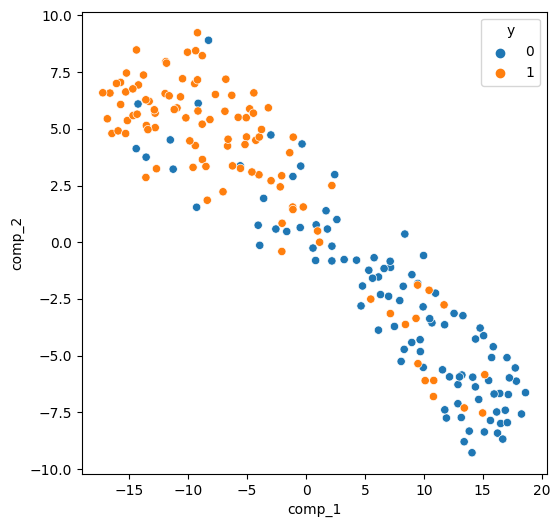

In [18]:
dim_reduction_df = viz.tsne_dim_reduction(train_prelogits.numpy(), 20, 2)
dim_reduction_df['y'] =  train_labels.numpy()
plt.figure( figsize=(6,6) )
# plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
sns.scatterplot(dim_reduction_df, x='comp_1', y='comp_2', hue='y')
plt.show()

In [19]:
train_probs = torch.softmax(train_logits, dim=-1)
trace_probs = torch.softmax(trace_logits, dim=-1)
train_probs_delta = torch.zeros_like(train_probs).scatter_(dim=-1, index=train_labels.unsqueeze(1), value=1.) - train_probs
trace_probs_delta = torch.zeros_like(trace_probs).scatter_(dim=-1, index=trace_labels.unsqueeze(1), value=1.) - trace_probs

train_probs_delta_normed = torch.nn.functional.normalize(train_probs_delta, p=2, dim=1)
trace_probs_delta_normed = torch.nn.functional.normalize(trace_probs_delta, p=2, dim=1)

In [20]:
# weights = train_prelogits @ trace_prelogits.T
train_embeddings_normed = torch.nn.functional.normalize(train_prelogits, p=2, dim=1)
trace_embeddings_normed = torch.nn.functional.normalize(trace_prelogits, p=2, dim=1)

In [21]:
((train_prelogits @ trace_prelogits.T) < 0).sum()

tensor(0)

In [44]:
train_probs_delta

tensor([[ 0.1469, -0.1469],
        [ 0.2091, -0.2091],
        [ 0.1432, -0.1432],
        [ 0.2995, -0.2995],
        [ 0.1105, -0.1105],
        [ 0.3086, -0.3086],
        [ 0.2495, -0.2495],
        [ 0.1863, -0.1863],
        [ 0.1287, -0.1287],
        [ 0.3841, -0.3841],
        [ 0.2312, -0.2312],
        [ 0.1722, -0.1722],
        [ 0.3234, -0.3234],
        [ 0.2020, -0.2020],
        [ 0.1050, -0.1050],
        [ 0.1897, -0.1897],
        [ 0.7801, -0.7801],
        [ 0.1053, -0.1053],
        [ 0.1395, -0.1395],
        [ 0.1728, -0.1728],
        [ 0.1109, -0.1109],
        [ 0.2793, -0.2793],
        [ 0.4127, -0.4127],
        [ 0.2305, -0.2305],
        [ 0.1976, -0.1976],
        [ 0.6136, -0.6136],
        [ 0.3378, -0.3378],
        [ 0.1996, -0.1996],
        [ 0.5388, -0.5388],
        [ 0.8574, -0.8574],
        [ 0.2018, -0.2018],
        [ 0.8269, -0.8269],
        [ 0.2264, -0.2264],
        [ 0.2391, -0.2391],
        [ 0.1448, -0.1448],
        [ 0.1282, -0

In [39]:
# label_ifs = (train_probs_delta @ trace_probs_delta.T)
label_ifs = (train_probs_delta_normed @ trace_probs_delta_normed.T)
label_ifs_threshold = (torch.sign(train_probs_delta) @ torch.sign(trace_probs_delta).T)
weights = util.cos_sim(train_prelogits, trace_prelogits)
# weights = train_embeddings_normed @ trace_embeddings_normed.T

In [23]:
label_ifs_threshold

tensor([[ 2., -2.,  2.,  ..., -2.,  2., -2.],
        [ 2., -2.,  2.,  ..., -2.,  2., -2.],
        [ 2., -2.,  2.,  ..., -2.,  2., -2.],
        ...,
        [-2.,  2., -2.,  ...,  2., -2.,  2.],
        [-2.,  2., -2.,  ...,  2., -2.,  2.],
        [-2.,  2., -2.,  ...,  2., -2.,  2.]])

In [34]:
torch.index_select(trace_probs,-1, trace_labels).shape

torch.Size([1310, 1310])

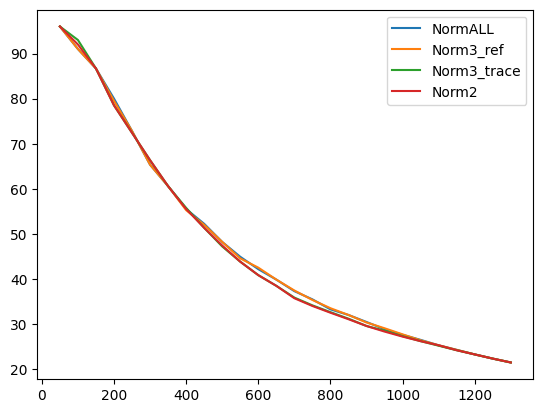

In [76]:
plot_ifs((train_probs_delta_normed @ trace_probs_delta_normed.T) * (train_embeddings_normed @ trace_embeddings_normed.T), 'NormALL', sum_class=False)
plot_ifs((train_probs_delta_normed @ trace_probs_delta_normed.T) * (train_embeddings_normed @ trace_prelogits.T), 'Norm3_ref', sum_class=False)
plot_ifs((train_probs_delta_normed @ trace_probs_delta_normed.T) * (train_prelogits @ trace_embeddings_normed.T), 'Norm3_trace', sum_class=False)
plot_ifs((train_probs_delta_normed @ trace_probs_delta_normed.T) * (train_prelogits @ trace_prelogits.T), 'Norm2', sum_class=False)
plt.legend()

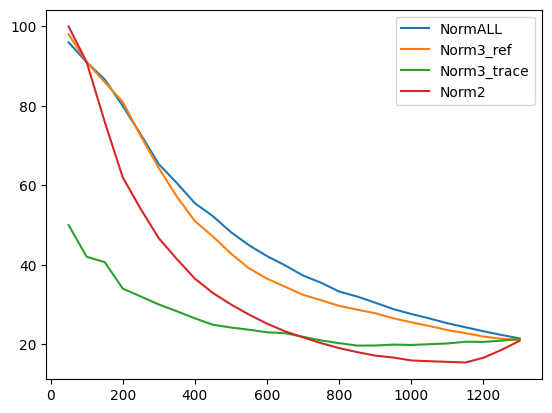

In [77]:
plot_ifs((train_probs_delta_normed @ trace_probs_delta_normed.T) * (train_embeddings_normed @ trace_embeddings_normed.T), 'NormALL', sum_class=False)
plot_ifs((train_probs_delta_normed @ trace_probs_delta.T) * (train_embeddings_normed @ trace_embeddings_normed.T), 'Norm3_ref', sum_class=False)
plot_ifs((train_probs_delta @ trace_probs_delta_normed.T) * (train_embeddings_normed @ trace_embeddings_normed.T), 'Norm3_trace', sum_class=False)
plot_ifs((train_probs_delta @ trace_probs_delta.T) * (train_embeddings_normed @ trace_embeddings_normed.T), 'Norm2', sum_class=False)

plt.legend()

In [65]:
gd_length =  trace_prelogits.norm(dim=-1) * trace_probs[torch.arange(len(trace_probs)), 1 - trace_labels]

In [134]:
weights = torch.cdist(train_prelogits.unsqueeze(0), trace_prelogits.unsqueeze(0)).squeeze(0)

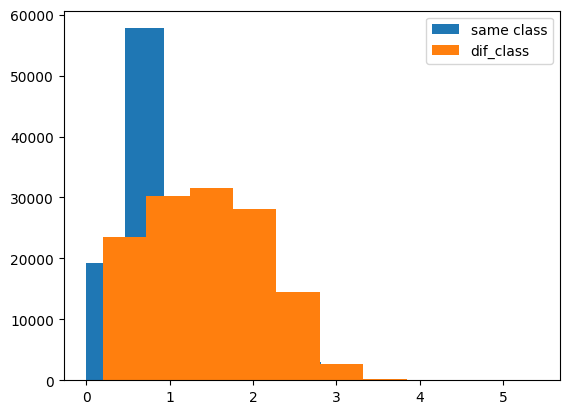

In [135]:
plt.hist(weights[(train_labels[:, None] == trace_labels[None, :])], label="same class")
plt.hist(weights[(train_labels[:, None] != trace_labels[None, :])], label="dif_class")
plot
plt.legend()